## If fetching data from Google Drive
My model

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# !rm -r bce

In [0]:
!unzip -qq 'DeepNet.zip'

# Dataset

In [0]:
!pip install -q kaggle

In [2]:
!mkdir .kaggle

import json
import os
token = {"username":"rvk007","key":"e88895c824e0311fffda49bb07438f33"}
with open('.kaggle/kaggle.json', 'w') as f:
  json.dump(token, f)

!chmod 600 /content/.kaggle/kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = '/content/.kaggle'
!kaggle datasets download -d shanwizard/modest-museum-dataset
!unzip -qq '/content/modest-museum-dataset.zip' 

100% 6.02G/6.03G [02:19<00:00, 35.2MB/s]
100% 6.03G/6.03G [02:19<00:00, 46.4MB/s]


In [0]:
%%time
!unzip -qq '/content/gdrive/My Drive/modest_museum_dataset/modest_museum_dataset.zip' -d .

CPU times: user 752 ms, sys: 117 ms, total: 869 ms
Wall time: 6min 57s


# Imports

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import PIL
import numpy as np
import random

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# Import Packages

In [0]:
from deepnet.data.dataset.modest import ModestMuseum
from deepnet.utils.cuda import initialze_cuda

from deepnet.model.models.model import MaskNet3, DepthMaskNet
from deepnet.model.train import Train

from deepnet.model.losses.loss_combination import BCE_RMSE_LOSS, SSIM_RMSE_LOSS, BCE_SSIM_LOSS, RMSE_SSIM_LOSS, SSIM_DICE_LOSS, RMSE_DICE_LOSS
from deepnet.model.losses.ssim import SSIM, MS_SSIM
from deepnet.model.losses.dice_loss import DiceLoss

from deepnet.utils.plot import Plot
from deepnet.utils.checkpoint import Checkpoint
from deepnet.utils.summary import summary
from deepnet.utils.tensorboard import Tensorboard

# Initialize Cuda

In [3]:
%%time
cuda, device = initialze_cuda(1)

Is CUDA Available? True
CPU times: user 8.81 ms, sys: 19 ms, total: 27.8 ms
Wall time: 37.3 ms


## Device Description

In [4]:
!nvidia-smi

Mon May 25 08:16:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
%%time 
modest = ModestMuseum(
    cuda= cuda,
    batch_size = 128,
    num_workers = 16,
    path = 'modest_museum_dataset',
    resize=(64,64),
    train_test_split=0.7,
    seed=1)

CPU times: user 6.67 s, sys: 312 ms, total: 6.98 s
Wall time: 6.99 s


# Dataloader

In [0]:
trainloader = modest.dataloader(train=True)
testloader = modest.dataloader(train=False)

# Dataset Visualization

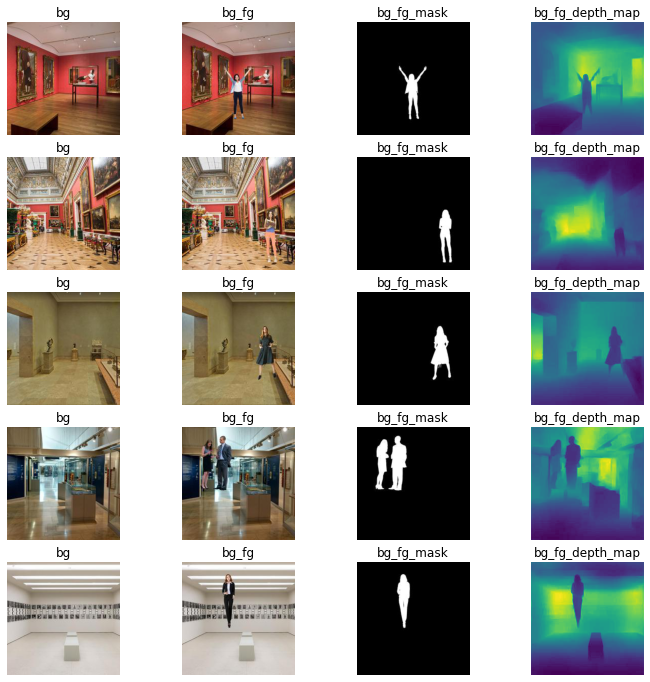

In [0]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

columns = 4
rows = 5

images = []
for i in range(rows):
    idx = random.randint(0, len(trainloader))
    batch = trainloader.dataset.dataset[idx]
    images.append(batch['bg'])
    images.append(batch['bg_fg'])
    images.append(batch['bg_fg_mask'])
    images.append(batch['bg_fg_depth'])

fig=plt.figure(figsize=(12,12))


for i in range(1, columns*rows +1):
    img = Image.open(images[i-1])
    fig.add_subplot(rows, columns, i)
    plt.axis('off')

    if images[i-1].split('/')[1] == 'bg':
      plt.title('bg')
      plt.imshow(img)

    elif images[i-1].split('/')[1] == 'bg_fg':
      plt.title('bg_fg')
      plt.imshow(img)

    elif images[i-1].split('/')[1] == 'bg_fg_mask':
      plt.title('bg_fg_mask')
      plt.imshow(img, cmap='gray')

    elif images[i-1].split('/')[1] == 'bg_fg_depth_map':
      plt.title('bg_fg_depth_map')
      plt.imshow(img)

plt.show()

# Model Architecture

In [7]:
%%time
model = DepthMaskNet()
model = model.to(device)
summary(model, {k:v for idx,(k,v) in enumerate(modest.input_size.items()) if idx<2 })

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            Conv2d-4         [-1, 16, 224, 224]           2,320
       BatchNorm2d-5         [-1, 16, 224, 224]              32
              ReLU-6         [-1, 16, 224, 224]               0
            Conv2d-7         [-1, 16, 224, 224]             448
       BatchNorm2d-8         [-1, 16, 224, 224]              32
              ReLU-9         [-1, 16, 224, 224]               0
           Conv2d-10         [-1, 16, 224, 224]           2,320
      BatchNorm2d-11         [-1, 16, 224, 224]              32
             ReLU-12         [-1, 16, 224, 224]               0
        MaxPool2d-13         [-1, 16, 112, 112]               0
           Conv2d-14         [-1, 16, 1

# Tensorboard

In [8]:
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

# Training
## Modify Learner Class

In [0]:
class ModestTrain(Train):
    def __init__(self):
        return

    def _fetch_data(self, batch, device):
        feature = {}
        feature['bg'] = batch['bg'].to(device)
        feature['bg_fg'] = batch['bg_fg'].to(device)
        
        target = {}
        target['bg_fg_mask'] = batch['bg_fg_mask'].to(device)
        target['bg_fg_depth'] = batch['bg_fg_depth'].to(device)
        return feature, target

    def _fetch_result(self, prediction):
        pred = {
            'bg_fg_mask' : (prediction[0]),
            'bg_fg_depth' : torch.sigmoid(prediction[1])
        }
        return pred

    def _fetch_sigmoid_data(self, prediction):
        pred = {
            'bg_fg_mask' : torch.sigmoid(prediction[0]),
            'bg_fg_depth' : torch.sigmoid(prediction[1])
        }
        return pred
        
modest_train = ModestTrain()

## Optimizer and Scheduler

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-8, momentum=0.9)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True,
                                                 threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0,
                                                 eps=1e-08)

## Sample Images for Tensorboard

In [11]:
%%time
img_idxes = random.sample(range(len(modest._test_data)), 32)

# Prepare Images
images = {
    'bg': modest._test_data[img_idxes[0]]['bg'].unsqueeze(0),
    'bg_fg': modest._test_data[img_idxes[0]]['bg_fg'].unsqueeze(0)
}

for idx in img_idxes[1:]:
    images['bg'] = torch.cat((
        images['bg'], modest._test_data[idx]['bg'].unsqueeze(0)
    ), 0)
    images['bg_fg'] = torch.cat((
        images['bg_fg'], modest._test_data[idx]['bg_fg'].unsqueeze(0)
    ), 0)


images['bg'] = images['bg'].to(device)
images['bg_fg'] = images['bg_fg'].to(device)

CPU times: user 385 ms, sys: 14 ms, total: 399 ms
Wall time: 661 ms


# BCE-RMSE Loss

In [0]:
model_bce_rmse = model

criterion = BCE_RMSE_LOSS()
checkpoint = Checkpoint('bce_rmse/checkpoint.pth', monitor='Loss',verbose=1)
tensorboard = Tensorboard('runs/bce_rmse',images)

In [13]:
%%time
epochs = 3

model_bce_rmse.learner(
    model_bce_rmse,
    tensorboard,
    modest_train,
    trainloader,
    testloader,
    device,
    optimizer,
    criterion,
    epochs,
    metrics=['rmse','iou'],
    callbacks=[scheduler, checkpoint]
)

Epoch 1:
2188/2188 [========] - 1545s 706ms/step|mask_loss: 0.0916|mask_rmse: 5.8118|mask_iou: 0.3718|depth_loss: 0.0916|depth_rmse: 5.8165|depth_iou: 0.3718

 Validation: |mask_loss: 0.068544 |mask_rmse: 9.384 |mask_iou: 0.481 |depth_loss: 0.068544 |depth_rmse: 9.386 |depth_iou: 0.481 


Epoch 00002: Loss improved from inf to 0.00052
Epoch 2:
2188/2188 [========] - 1516s 693ms/step|mask_loss: 0.0651|mask_rmse: 9.6039|mask_iou: 0.4876|depth_loss: 0.0651|depth_rmse: 9.6164|depth_iou: 0.4871

 Validation: |mask_loss: 0.059371 |mask_rmse: 10.075 |mask_iou: 0.493 |depth_loss: 0.059371 |depth_rmse: 10.077 |depth_iou: 0.493 


Epoch 00003: Loss improved from 0.00052 to 0.00049
Epoch 3:
2188/2188 [========] - 1507s 689ms/step|mask_loss: 0.0607|mask_rmse: 10.4695|mask_iou: 0.4972|depth_loss: 0.0607|depth_rmse: 10.4833|depth_iou: 0.4967

 Validation: |mask_loss: 0.054656 |mask_rmse: 10.994 |mask_iou: 0.499 |depth_loss: 0.054656 |depth_rmse: 10.996 |depth_iou: 0.499 


Epoch 00004: Loss improved

In [18]:
%%time
#epoch 4-6
epochs = 3

model_bce_rmse.learner(
    model_bce_rmse,
    tensorboard,
    modest_train,
    trainloader,
    testloader,
    device,
    optimizer,
    criterion,
    epochs,
    metrics=['rmse','iou'],
    callbacks=[scheduler, checkpoint]
)

Epoch 1:
2188/2188 [========] - 1490s 681ms/step|mask_loss: 0.0590|mask_rmse: 11.0143|mask_iou: 0.5019|depth_loss: 0.0590|depth_rmse: 11.0288|depth_iou: 0.5014

 Validation: |mask_loss: 0.054497 |mask_rmse: 11.324 |mask_iou: 0.504 |depth_loss: 0.054497 |depth_rmse: 11.326 |depth_iou: 0.504 


Epoch 00002: Loss improved from inf to 0.00044
Epoch 2:
2188/2188 [========] - 1486s 679ms/step|mask_loss: 0.0567|mask_rmse: 11.4335|mask_iou: 0.5047|depth_loss: 0.0567|depth_rmse: 11.4486|depth_iou: 0.5042

 Validation: |mask_loss: 0.063551 |mask_rmse: 11.315 |mask_iou: 0.509 |depth_loss: 0.063551 |depth_rmse: 11.317 |depth_iou: 0.509 


Epoch 00003: Loss did not improve from 0.00044
Epoch 3:
2188/2188 [========] - 1484s 678ms/step|mask_loss: 0.0553|mask_rmse: 11.7774|mask_iou: 0.5073|depth_loss: 0.0553|depth_rmse: 11.7927|depth_iou: 0.5065

 Validation: |mask_loss: 0.052409 |mask_rmse: 12.045 |mask_iou: 0.506 |depth_loss: 0.052409 |depth_rmse: 12.048 |depth_iou: 0.506 


Epoch 00004: Loss improv

# Training on 96 x 96

In [22]:
%%time 

modest = ModestMuseum(
    cuda= cuda,
    batch_size = 128,
    num_workers = 16,
    path = 'modest_museum_dataset',
    resize=(96,96),
    train_test_split=0.7,
    seed=1)

nexttrainloader = modest.dataloader(train=True)
nexttestloader = modest.dataloader(train=False)

CPU times: user 6.95 s, sys: 333 ms, total: 7.29 s
Wall time: 7.29 s


In [23]:
%%time
#epoch 6-9
epochs = 3
model_bce_rmse.learner(
    model_bce_rmse,
    tensorboard,
    modest_train,
    nexttrainloader,
    nexttestloader,
    device,
    optimizer,
    criterion,
    epochs,
    metrics=['rmse','iou'],
    callbacks=[scheduler, checkpoint]
)

Epoch 1:
2188/2188 [========] - 1973s 902ms/step|mask_loss: 0.0581|mask_rmse: 12.5501|mask_iou: 0.5165|depth_loss: 0.0581|depth_rmse: 12.5614|depth_iou: 0.5159

 Validation: |mask_loss: 0.055791 |mask_rmse: 13.344 |mask_iou: 0.514 |depth_loss: 0.055791 |depth_rmse: 13.347 |depth_iou: 0.514 


Epoch 00002: Loss improved from inf to 0.00045
Epoch 2:
2188/2188 [========] - 1953s 893ms/step|mask_loss: 0.0527|mask_rmse: 13.6757|mask_iou: 0.5202|depth_loss: 0.0527|depth_rmse: 13.6925|depth_iou: 0.5194

 Validation: |mask_loss: 0.050552 |mask_rmse: 14.01 |mask_iou: 0.523 |depth_loss: 0.050552 |depth_rmse: 14.013 |depth_iou: 0.523 


Epoch 00003: Loss improved from 0.00045 to 0.00040
Epoch 3:
2188/2188 [========] - 1959s 895ms/step|mask_loss: 0.0515|mask_rmse: 14.0979|mask_iou: 0.5214|depth_loss: 0.0515|depth_rmse: 14.1158|depth_iou: 0.5210

 Validation: |mask_loss: 0.059142 |mask_rmse: 13.713 |mask_iou: 0.525 |depth_loss: 0.059142 |depth_rmse: 13.715 |depth_iou: 0.525 


Epoch 00004: Loss did

In [37]:
optimizer.param_groups[0]['lr'] = 0.01

0.01

In [38]:
%%time
#epoch 9-12
epochs = 3
model_bce_rmse.learner(
    model_bce_rmse,
    tensorboard,
    modest_train,
    nexttrainloader,
    nexttestloader,
    device,
    optimizer,
    criterion,
    epochs,
    metrics=['rmse','iou'],
    callbacks=[scheduler, checkpoint]
)

Epoch 1:
2188/2188 [========] - 1955s 893ms/step|mask_loss: 0.0458|mask_rmse: 14.6457|mask_iou: 0.5224|depth_loss: 0.0458|depth_rmse: 14.6642|depth_iou: 0.5220

 Validation: |mask_loss: 0.045817 |mask_rmse: 14.662 |mask_iou: 0.523 |depth_loss: 0.045817 |depth_rmse: 14.665 |depth_iou: 0.523 


Epoch 00002: Loss improved from inf to 0.00036
Epoch 2:
2188/2188 [========] - 1980s 905ms/step|mask_loss: 0.0454|mask_rmse: 14.7100|mask_iou: 0.5224|depth_loss: 0.0454|depth_rmse: 14.7293|depth_iou: 0.5220

 Validation: |mask_loss: 0.046279 |mask_rmse: 14.709 |mask_iou: 0.523 |depth_loss: 0.046279 |depth_rmse: 14.712 |depth_iou: 0.523 


Epoch 00003: Loss improved from 0.00036 to 0.00036
Epoch 3:
2188/2188 [========] - 1980s 905ms/step|mask_loss: 0.0452|mask_rmse: 14.7655|mask_iou: 0.5225|depth_loss: 0.0452|depth_rmse: 14.7849|depth_iou: 0.5220

 Validation: |mask_loss: 0.046272 |mask_rmse: 14.782 |mask_iou: 0.522 |depth_loss: 0.046272 |depth_rmse: 14.785 |depth_iou: 0.522 


Epoch 00004: Loss im

# Training on 128 x 128

In [0]:
%%time 

modest = ModestMuseum(
    cuda= cuda,
    batch_size = 128,
    num_workers = 16,
    path = 'modest_museum_dataset',
    resize=(128,128),
    train_test_split=0.7,
    seed=1)

nexttrainloader = modest.dataloader(train=True)
nexttestloader = modest.dataloader(train=False)

In [0]:
%%time
#epoch 9-12
epochs = 3
model_bce_rmse.learner(
    model_bce_rmse,
    tensorboard,
    modest_train,
    nexttrainloader,
    nexttestloader,
    device,
    optimizer,
    criterion,
    epochs,
    metrics=['rmse','iou'],
    callbacks=[scheduler, checkpoint]
)

In [0]:
import pickle

def saveit():
    with open('runs/depth.pkl', 'wb') as f:
        a = model_bce_rmse.results
        pickle.dump(a, f)

In [17]:
saveit()
!mkdir imgs
!mv *.png imgs
!zip -r bce_rmse.zip bce_rmse runs imgs
!mv bce_rmse.zip '/content/gdrive/My Drive'

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


  adding: bce_rmse/ (stored 0%)
  adding: bce_rmse/checkpoint.pth (deflated 8%)
  adding: runs/ (stored 0%)
  adding: runs/depth.pkl (deflated 49%)
  adding: runs/bce_rmse/ (stored 0%)
  adding: runs/bce_rmse/events.out.tfevents.1590394623.31aa780fcda4.326.0 (deflated 1%)
  adding: imgs/ (stored 0%)
  adding: imgs/img_1_result_1.png (deflated 0%)
  adding: imgs/img_0_result_1.png (deflated 3%)
  adding: imgs/img_1_result_3.png (deflated 0%)
  adding: imgs/img_1_result_2.png (deflated 0%)
  adding: imgs/img_0_result_2.png (deflated 3%)
  adding: imgs/img_0_result_3.png (deflated 3%)


In [0]:
def loadit():
    with open('runs/depth.pkl', 'rb') as f:
        a = pickle.load(f)
    return a

In [0]:
# a = loadit()
# import torch
# checkpoint = torch.load('/content/bce_rmse/checkpoint.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# learner.optimizer = optimizer
# learner.train_losses = a['train_losses']
# learner.val_losses = a['val_losses']
# learner.train_metrics = a['train_metrics']
# learner.val_metrics = a['val_metrics']
# model.set_learner(learner)

In [14]:
print('hee')

hee
